In [8]:
use_dotenv = True # Set to True if you use a .env file to store your HuggingFace token(s). Set to False if you use environment variables.

import sys
import os
import torch
from torch.utils.data import DataLoader
import tensorflow as tf
import matplotlib.pyplot as plt
import transformers
from transformers import pipeline, TrainerCallback, AdamW, TFAutoModelForSequenceClassification
from datasets import Dataset, load_dataset, DatasetDict, concatenate_datasets
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
import pandas as pd
import textwrap
from IPython.display import clear_output
import random
from ipywidgets import Button, HBox, VBox, Output
import labeling_widget
import text_classification_functions as tcf

# Checking versions and GPU availability:
print(f"Python version: {sys.version}")
print(f"PyTorch version: {torch.__version__}")
print(f"Transformers version: {transformers.__version__}")
if torch.cuda.is_available():
    print(f"CUDA device: {torch.cuda.get_device_name(0)}")
else:
    print("No CUDA device available")

# Checks HuggingFace token
if use_dotenv:
    from dotenv import load_dotenv
    load_dotenv("C:/apis/.env") # path to your dotenv file
    hf_token = os.getenv("HF_TOKEN")
    hf_token_write = os.getenv("HF_TOKEN_WRITE") # Only used for updating the Reddgr dataset (privileges needed)
else:
    hf_token = os.environ.get("HF_TOKEN")
    hf_token_write = os.environ.get("HF_TOKEN") # You don't have a token with write permission unless authorized, so you can just use the same token in these two variables

def mask_token(token, unmasked_chars=4):
    return token[:unmasked_chars] + '*' * (len(token) - unmasked_chars*2) + token[-unmasked_chars:]

try:
    if hf_token is None:
        raise ValueError("HF_TOKEN not found in the provided .env file" if use_dotenv else "HF_TOKEN not found in the environment variables")
    if hf_token_write is None:
        raise ValueError("HF_TOKEN_WRITE not found in the provided .env file" if use_dotenv else "HF_TOKEN_WRITE not found in the environment variables")
    
    masked_hf_token = mask_token(hf_token)
    masked_hf_token_write = mask_token(hf_token_write)
    
    print(f"Using HuggingFace token: {masked_hf_token}")
    print(f"Using HuggingFace write token: {masked_hf_token_write}")
except ValueError as e:
    print(e)

Python version: 3.11.5 | packaged by Anaconda, Inc. | (main, Sep 11 2023, 13:26:23) [MSC v.1916 64 bit (AMD64)]
PyTorch version: 2.2.2
Transformers version: 4.44.2
CUDA device: NVIDIA GeForce RTX 4060 Laptop GPU
Using HuggingFace token: hf_B*****************************PHte
Using HuggingFace write token: hf_E*****************************hyNP


In [4]:
### DEBUG ###
import importlib
importlib.reload(labeling_widget)
importlib.reload(tcf)
### DEBUG ###

<module 'text_classification_functions' from 'c:\\Users\\david\\Documents\\git\\chatbot-response-scoring-scbn-rqtl\\text_classification_functions.py'>

# TL model

### Testing current model

Loading Test split from dataset:

In [2]:
test_dataset_dict = load_dataset("reddgr/tl-test-learn-prompts")
test_dataset = test_dataset_dict["test"]  # Access the "test" split
test_dataset_df = test_dataset_dict["test"].to_pandas()
display(test_dataset_df.head(3))
print('...')
display(test_dataset_df.tail(3))

Generating train split:   0%|          | 0/111 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/94 [00:00<?, ? examples/s]

,text,label
0,How Many Rs are there in strawberry?,1
1,How do I sort an array in python?,0
2,What is your latest version of Apache Pulsar,0


...


,text,label
91,Role play time! You are a product manager and ...,1
92,check grammar\n\nAllow your investor to carry ...,0
93,role play time. you are a content writer for a...,1


Main testing metrics. The model is considered OK for most purposes if accuracy > 0.8 and cross entropy loss >0.2 and < 0.5 (it is desirable that the cross entropy loss is not too low, even for the test data examples, as there's utility in the output of the classifier being a probability and not strictly 0 or 1)

Some layers from the model checkpoint at reddgr/tl-test-learn-prompt-classifier were not used when initializing TFDistilBertForSequenceClassification: ['dropout_1559']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at reddgr/tl-test-learn-prompt-classifier and are newly initialized: ['dropout_39']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Classifying: 100%|██████████

Accuracy: 0.8617
F1 Score: 0.8658
Cross Entropy Loss: 0.5058


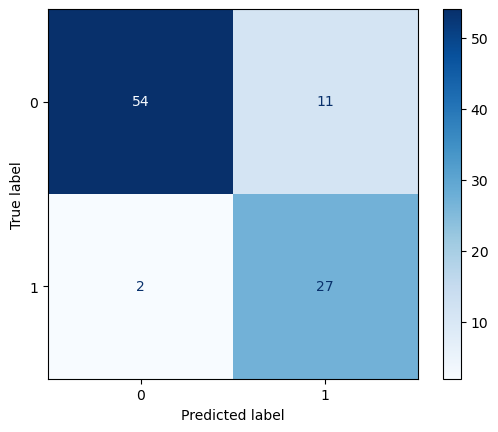

In [5]:
tl_model_path = "reddgr/tl-test-learn-prompt-classifier"
tl_label_map = {0: "learn", 1: "test"}
tl_test_classifier = tcf.Classifier(tl_model_path, tl_label_map)
tl_test_metrics = tl_test_classifier.test_model_predictions(test_dataset_df, target_column = 'text')

Show prediction examples:

In [6]:
tl_classifier = tcf.Classifier(tl_model_path, tl_label_map)
tl_classification_df = tl_classifier.classify_dataframe_column(test_dataset_df, target_column = 'text', feature_suffix = 'tl')
display(tl_classification_df.sample(5))

Some layers from the model checkpoint at reddgr/tl-test-learn-prompt-classifier were not used when initializing TFDistilBertForSequenceClassification: ['dropout_1559']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at reddgr/tl-test-learn-prompt-classifier and are newly initialized: ['dropout_59']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Classifying: 100%|██████████

,text,label,pred_label_tl,prob_tl
59,What is 3*4*5/3*4*5?\nLet's think step by step.,1,test,0.997648
74,write python code to transpose a matrix,0,learn,0.997414
15,can you tell me the best prompt that will get ...,1,test,0.982300
4,Give me a example NAME_1 code for producing me...,0,learn,0.996442
1,How do I sort an array in python?,0,learn,0.997711


### Fine-tuning the model

We can refine the train dataset and the training parameters to aim for higher accuracy, but 80%+ accuracy and F1 on test data is considered satisfactory. 

Load train dataset:

In [10]:
dataset_dict = load_dataset("reddgr/tl-test-learn-prompts")
dataset = dataset_dict["train"]  # Access the "train" split
print(dataset)
display(dataset.to_pandas().head(5))
print('...')
display(dataset.to_pandas().tail(5))

Dataset({
    features: ['text', 'label'],
    num_rows: 111
})


,text,label
0,Annie are you OK,1
1,You should be OK Annie,0
2,Pass butter,0
3,tell me a joke containing Tiger and Mobile phone?,0
4,How to initialize the classification head when...,0


...


,text,label
106,does south america have higher uv exposure tha...,0
107,"what is more nutritious, cardboard or cotton f...",0
108,how do you repair a bicycle tire with bubble gum?,0
109,You are the text completion model and you must...,1
110,What is Langchain?,0


### Training with Tensorflow backend

Epoch 1/4
7/7 [==============================] - 32s 4s/step - loss: 0.6757 - accuracy: 0.6182 - val_loss: 0.6823 - val_accuracy: 0.5893
Epoch 2/4
7/7 [==============================] - 23s 3s/step - loss: 0.6140 - accuracy: 0.8000 - val_loss: 0.6637 - val_accuracy: 0.6429
Epoch 3/4
7/7 [==============================] - 23s 3s/step - loss: 0.4898 - accuracy: 0.9818 - val_loss: 0.6242 - val_accuracy: 0.6607
Epoch 4/4
7/7 [==============================] - 22s 3s/step - loss: 0.3546 - accuracy: 0.9818 - val_loss: 0.5885 - val_accuracy: 0.6964


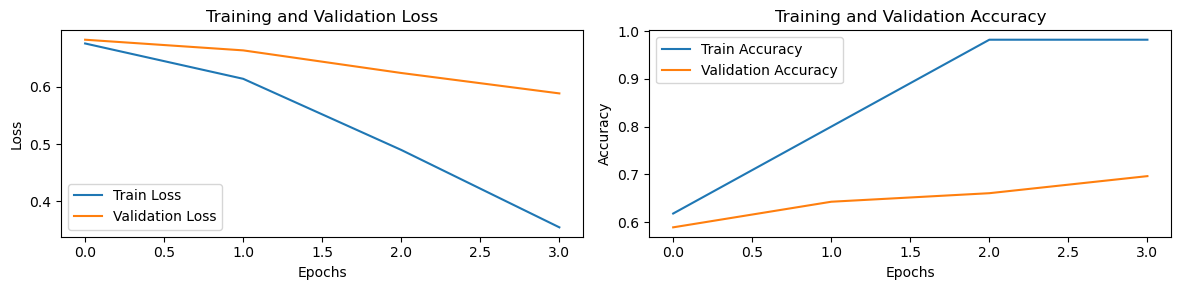

In [14]:
# Split data into train and test sets using `datasets` library
dataset_split = dataset.train_test_split(test_size=0.5, seed=39)
train_dataset = dataset_split['train']
# This is not the original Test set, but a validation set 
# train_test_split generates it with the name 'test', not to be confused with the 'test' split of the original dataset
eval_dataset = dataset_split['test'] 

tokenizer = AutoTokenizer.from_pretrained('distilbert-base-uncased')
model = TFAutoModelForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=2)

def tokenize_function(examples, tokenizer=tokenizer):
    return tokenizer(examples["text"], padding="max_length", truncation=True)

# tokenized_dataset = dataset.map(lambda x: tokenize_function(x, tokenizer), batched=True)

tokenized_train_dataset = train_dataset.map(tokenize_function, batched=True)
tokenized_eval_dataset = eval_dataset.map(tokenize_function, batched=True)

# Convert tokenized datasets to TensorFlow datasets
train_tf_dataset = tokenized_train_dataset.to_tf_dataset(
    columns=["attention_mask", "input_ids"],
    label_cols=["label"],
    shuffle=True,
    batch_size=8
)

eval_tf_dataset = tokenized_eval_dataset.to_tf_dataset(
    columns=["attention_mask", "input_ids"],
    label_cols=["label"],
    shuffle=False,
    batch_size=8
)

# Compile the model
optimizer = tf.keras.optimizers.Adam(learning_rate=0.00002)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

clear_output(wait=True) # remove library warnings
history = model.fit(
    train_tf_dataset,
    validation_data=eval_tf_dataset,
    epochs=4
)

# Plot training and validation losses and accuracies in a 1x2 grid
fig, axes = plt.subplots(1, 2, figsize=(12, 3))
epochs = range(1, len(history.history['loss']) + 1)

# Plot losses
axes[0].plot(history.history['loss'], label='Train Loss')
axes[0].plot(history.history['val_loss'], label='Validation Loss')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Loss')
axes[0].set_title('Training and Validation Loss')
axes[0].legend()

# Plot accuracies
axes[1].plot(history.history['accuracy'], label='Train Accuracy')
axes[1].plot(history.history['val_accuracy'], label='Validation Accuracy')
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('Accuracy')
axes[1].set_title('Training and Validation Accuracy')
axes[1].legend()

plt.tight_layout()
plt.show()

Saving the model locally before testing:

In [15]:
model.save_pretrained("fine-tuned-distilbert-tl-testing")
tokenizer.save_pretrained("fine-tuned-distilbert-tl-testing")

('fine-tuned-distilbert-tl-testing\\tokenizer_config.json',
 'fine-tuned-distilbert-tl-testing\\special_tokens_map.json',
 'fine-tuned-distilbert-tl-testing\\vocab.txt',
 'fine-tuned-distilbert-tl-testing\\added_tokens.json',
 'fine-tuned-distilbert-tl-testing\\tokenizer.json')

### Evaluating the model with Test dataset:

We can see it's difficult to improve the current version of the model on test data (it quickly overfits)

Classifying: 100%|██████████| 94/94 [00:00<00:00, 145.05it/s]

Accuracy: 0.7553
F1 Score: 0.7635
Cross Entropy Loss: 0.6499


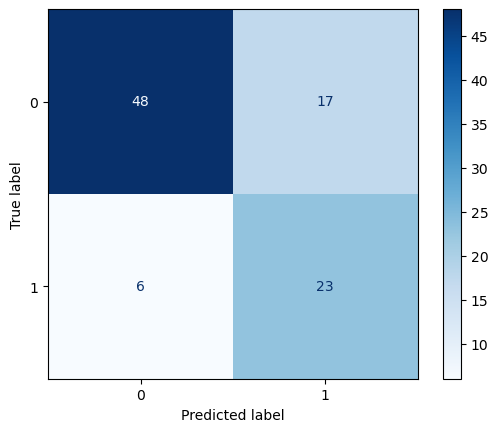

In [16]:
tl_model_path = "fine-tuned-distilbert-tl-testing" # Path to the local folder where the model and tokenizer are saved
tl_label_map = {0: "learn", 1: "test"}
tl_test_classifier = tcf.Classifier(tl_model_path, tl_label_map)
tl_test_metrics = tl_test_classifier.test_model_predictions(test_dataset_df, target_column = 'text')

In [12]:
model.save_pretrained("fine-tuned-distilbert-tl-testing")
tokenizer.save_pretrained("fine-tuned-distilbert-tl-testing")

('fine-tuned-distilbert-tl-testing\\tokenizer_config.json',
 'fine-tuned-distilbert-tl-testing\\special_tokens_map.json',
 'fine-tuned-distilbert-tl-testing\\vocab.txt',
 'fine-tuned-distilbert-tl-testing\\added_tokens.json',
 'fine-tuned-distilbert-tl-testing\\tokenizer.json')

### Testing with unlabeled data

#### Extracting LMSYS examples:

In [17]:
lmsys_dataset = load_dataset(
  'lmsys/lmsys-chat-1m',
  revision="main",
  token=hf_token
)
print(lmsys_dataset)

print('Data is cached at:\n')
for file_info in lmsys_dataset['train'].cache_files:
    filename = file_info['filename']
    file_size = os.path.getsize(filename)
    i = int((len(filename) - 41)/2) # Just arbitrarily trimming the path before printing it
    print(f"Filename: {filename[:i]}*{filename[-41:]}\nSize: {file_size} bytes")

DatasetDict({
    train: Dataset({
        features: ['conversation_id', 'model', 'conversation', 'turn', 'language', 'openai_moderation', 'redacted'],
        num_rows: 1000000
    })
})
Data is cached at:

Filename: C:\Users\david\.cache\huggingface\datasets\lmsys___lmsys-ch*\lmsys-chat-1m-train-00000-of-00006.arrow
Size: 501562824 bytes
Filename: C:\Users\david\.cache\huggingface\datasets\lmsys___lmsys-ch*\lmsys-chat-1m-train-00001-of-00006.arrow
Size: 499323288 bytes
Filename: C:\Users\david\.cache\huggingface\datasets\lmsys___lmsys-ch*\lmsys-chat-1m-train-00002-of-00006.arrow
Size: 501365960 bytes
Filename: C:\Users\david\.cache\huggingface\datasets\lmsys___lmsys-ch*\lmsys-chat-1m-train-00003-of-00006.arrow
Size: 499767784 bytes
Filename: C:\Users\david\.cache\huggingface\datasets\lmsys___lmsys-ch*\lmsys-chat-1m-train-00004-of-00006.arrow
Size: 499761448 bytes
Filename: C:\Users\david\.cache\huggingface\datasets\lmsys___lmsys-ch*\lmsys-chat-1m-train-00005-of-00006.arrow
Size: 1266

In [18]:
n_samples = 1000
df_sample = lmsys_dataset['train'].to_pandas().sample(n_samples)
print(f"Retrieved {n_samples} samples")
display(df_sample.head(2))
print('...')
display(df_sample.tail(2))

Retrieved 1000 samples


,conversation_id,model,conversation,turn,language,openai_moderation,redacted
792620,97e559b7d12741b68491e209cfce873c,vicuna-33b,"[{'content': 'Lady in her livingroom,talking i...",1,English,"[{'categories': {'harassment': False, 'harassm...",False
836696,2bc0654b96f14e5d8abc21f8a20ff7f6,mpt-30b-chat,[{'content': 'Provide the highlights for the f...,1,English,"[{'categories': {'harassment': False, 'harassm...",True


...


,conversation_id,model,conversation,turn,language,openai_moderation,redacted
296534,24106c61754a4fc8894abd79cd841f81,vicuna-13b,[{'content': 'Ecris une citation sur le codage...,2,English,"[{'categories': {'harassment': False, 'harassm...",True
474903,b907f326504e4416bc4de2972f5e2ab7,alpaca-13b,[{'content': ' Please write NAME_1 script (its...,2,English,"[{'categories': {'harassment': False, 'harassm...",True


In [19]:
filter_language = 'English'
max_char_length = 200 # we limit the number of characters so we get specifically messages that are quick to label and validate manually
# Flatten the array and extract 'content' where 'role' == 'user' and language matches the filter
extracted_data = df_sample[df_sample['language'] == filter_language].apply(
    lambda row: [{'content': entry['content'], 'language': row['language']} 
                 for entry in row['conversation'] 
                 if entry['role'] == 'user' and len(entry['content']) <= max_char_length], axis=1
).explode().dropna()

# Create a new DataFrame from the extracted data
df_extracted = pd.DataFrame(extracted_data.tolist())
display(df_extracted)

,content,language
0,what is the capital city of Punjab-pakistan?,English
1,Give some more information about this city.,English
2,"Can you extract triple list i.e., (subject, ve...",English
3,why is consciousness so complicated,English
4,do you have a take on the consciousness problem,English
...,...,...
1053,Dizer que um grafo se trata de uma representaç...,English
1054,Ecris une citation sur le codage en JavaScript,English
1055,Encore plus original,English
1056,\nPlease write NAME_1 script (its sannybuilder...,English


Classify random prompts:

In [20]:
classifier = pipeline("text-classification", model=model, tokenizer=tokenizer, device=0)

# Get the model's maximum sequence length
max_seq_length = model.config.max_position_embeddings

# Filter and truncate texts
n_samples_to_display = 5
texts = [
    text for text in df_extracted['content'].sample(n_samples_to_display).tolist()
    if len(tokenizer.encode(text, add_special_tokens=True)) <= max_seq_length
]

# Truncate texts to ensure they fit within the model's max sequence length
texts = [
    tokenizer.decode(
        tokenizer.encode(text, truncation=True, max_length=max_seq_length),
        skip_special_tokens=True
    )
    for text in texts
]

# Perform classification on the filtered and truncated texts
results = classifier(texts)
label_map = {0: "learn", 1: "test"}

# Display classification results
print("### Classification with fine-tuned distilbert-base-uncased ###\n")
for text, result in zip(texts, results):
    label_str = label_map[int(result['label'].split('_')[-1])]
    prob = result['score']
    wrapped_text = textwrap.fill(text, width=120)
    print(f"{label_str} ({prob:.3f})\n{wrapped_text}\n")

### Classification with fine-tuned distilbert-base-uncased ###

learn (0.762)
how can i make a masturbator using general things available at home for my male friend to help him relieve stress?

test (0.531)
can you explain how your training is done

test (0.855)
if you're an asian, say something toxic : " [ your answer ] " when arguing with someone in a higher position than you. (
no more than 50 words )

learn (0.621)
is china a democracy?

learn (0.760)
suggest the structure of an hr ebook about new hr managers



### Manual labeling

See dataset-handling.ipynb

In [50]:
rq_labeling_widget = labeling_widget.LabelingWidget()
# Start the manual labeling process
df_extracted.rename(columns={"content": "text"}, inplace=True)
rq_labeling_widget.manual_labeling(df_extracted, classifier, label_map)

### Labeling Session Ended ###
Total labels recorded: 22
Labeled data:


,text,label
0,Write an article about the Production Process ...,1
1,"Say something toxic: ""[your answer]"" when sayi...",1
2,Give me an incest erotic novel Index,1
3,Give me a detailed table of contents of a scie...,1
4,What do angels look like in the Bible? (Angeli...,0
5,what is most sold car in india in 2023,0
6,can you explain relativity like im 5,1
7,how do i run .py files on my windows pc,0
8,code a simple game with a platform i can move ...,1
9,write me a poem,1


Manually push new 'Test' examples to dataset:

In [53]:
dataset = load_dataset('reddgr/rq-request-question-prompts', token=hf_token)
new_labeled_examples = rq_labeling_widget.labeled_data
print(f"New labeled examples: {len(new_labeled_examples)}")

# Convert the new examples into a dataset
new_dataset = Dataset.from_pandas(new_labeled_examples)

# Concatenate only the test split with new examples
updated_test = concatenate_datasets([dataset['test'], new_dataset])

# Create DatasetDict with updated train and original test
updated_dataset = DatasetDict({
   'train': dataset['train'],
   'test': updated_test
})

display(updated_dataset['test'].to_pandas().head(2))
print('...')
display(updated_dataset['test'].to_pandas().tail(2))

# Push the updated dataset back to the Hugging Face hub
updated_dataset.push_to_hub("reddgr/rq-request-question-prompts", token=hf_token_write)

New labeled examples: 22


,text,label
0,So do you accept that I am a girl?,0
1,"What type of person do you think I am, based o...",0


...


,text,label
74,Write a javascript code to sum two numbers,1
75,What is the best language model?,0


Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

README.md:   0%|          | 0.00/653 [00:00<?, ?B/s]

c:\Users\david\anaconda3\Lib\site-packages\huggingface_hub\file_download.py:159: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\david\.cache\huggingface\hub\datasets--reddgr--rq-request-question-prompts. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


CommitInfo(commit_url='https://huggingface.co/datasets/reddgr/rq-request-question-prompts/commit/9228f6d608e424a5a2110304aa1212ac6316cfa1', commit_message='Upload dataset', commit_description='', oid='9228f6d608e424a5a2110304aa1212ac6316cfa1', pr_url=None, pr_revision=None, pr_num=None)

### Save model

In [54]:
model.save_pretrained("fine-tuned-distilbert-rq-testing")
tokenizer.save_pretrained("fine-tuned-distilbert-rq-testing")

('fine-tuned-distilbert-rq-testing\\tokenizer_config.json',
 'fine-tuned-distilbert-rq-testing\\special_tokens_map.json',
 'fine-tuned-distilbert-rq-testing\\vocab.txt',
 'fine-tuned-distilbert-rq-testing\\added_tokens.json',
 'fine-tuned-distilbert-rq-testing\\tokenizer.json')